first 15 hidden states:  tf.Tensor([0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (3273,)
v1 state shape:   (3273,)
error 0.50076383
Epoch: 1 batch #: 0  of 84 sample #: 499 reconstruction error: 0.002139
Epoch: 1 batch #: 1  of 84 sample #: 499 reconstruction error: 0.001222
Epoch: 1 batch #: 2  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 3  of 84 sample #: 499 reconstruction error: 0.001528
Epoch: 1 batch #: 4  of 84 sample #: 499 reconstruction error: 0.002444
Epoch: 1 batch #: 5  of 84 sample #: 499 reconstruction error: 0.009777
Epoch: 1 batch #: 6  of 84 sample #: 499 reconstruction error: 0.005194
Epoch: 1 batch #: 7  of 84 sample #: 499 reconstruction error: 0.001222
Epoch: 1 batch #: 8  of 84 sample #: 499 reconstruction error: 0.002444
Epoch: 1 batch #: 9  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 10  of 84 sample #: 499 reconstruction error: 0.00855

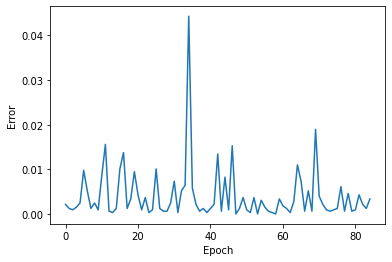

In [1]:
from flask import Flask, jsonify, request 
import os
import os.path
import json
import sys
import pandas as pd
import numpy as np
from operator import itemgetter
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import time
from itertools import combinations
import time
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
 


customer_df = pd.read_csv('customerdata.csv',low_memory=False)
items_df = customer_df[["product_item_id", "PRODUCT_NAME", "CATEGORY"]]
items_df = items_df.drop_duplicates()
items_df = items_df.reset_index(drop = True)
items_df = pd.DataFrame(items_df.groupby('product_item_id')["PRODUCT_NAME"].apply(list)).reset_index()
purchase_df=customer_df.groupby(['CUSTOMER_ID','product_item_id']).size().reset_index(name='COUNT')
purchase_df['COUNT'] = 1
user_item_df = purchase_df.pivot(index='CUSTOMER_ID', columns='product_item_id', values='COUNT')
user_item_df.shape
user_item_df.fillna(0).values.max()
norm_item_purchase = user_item_df.fillna(0)
trX = norm_item_purchase.values
trX[0:5]

hiddenUnits = 20
visibleUnits =  len(user_item_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

#Phase 1: Input Processing
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)
print("first 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

start_time=time.time()
epochs = 1 #change to 5
batchsize = 500 #change to 500
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)



#for i in range(epochs):
#    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
#        batch = trX[start:end]
#        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        prv_w = cur_w
#        prv_vb = cur_vb
#        prv_hb = cur_hb
#    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
#    print (errors[-1])
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()



In [2]:
trX,trX.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (42315, 3273))

In [3]:
from numpy import save
from numpy import load
import torch

In [4]:
save('data_count.npy', trX)
data = load('data_count.npy')

In [6]:
data,data.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (42315, 3273))

In [7]:
W.shape,hb.shape,vb.shape


(TensorShape([3273, 20]), TensorShape([20]), TensorShape([3273]))

In [8]:
torch.save(W, 'count_tensor_W.pt')
torch.save(hb, 'count_tensor_hb.pt')
torch.save(vb, 'count_tensor_vb.pt')

In [9]:
W_1=torch.load('count_tensor_W.pt')
hb_1=torch.load('count_tensor_hb.pt')
vb_1=torch.load('count_tensor_vb.pt')

In [10]:
W_1.shape,hb_1.shape,vb_1.shape

(TensorShape([3273, 20]), TensorShape([20]), TensorShape([3273]))

In [11]:
visibleUnits

3273